In [3]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import IPython.display as display
from matplotlib import animation

In [5]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)


2.6.0
0.21.0


In [21]:
!pip install matplotlib --quiet

In [22]:
!pip install torch --quiet

In [25]:
import torch
print(torch.cuda.is_available())


False


In [27]:
from nmnist import augment, NMNISTDataset

In [35]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 34*34*2, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, 512, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 10, weight_norm=True),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike
    
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

In [71]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

device = torch.device('cpu')
#device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

training_set = NMNISTDataset(train=True, transform=augment)
testing_set  = NMNISTDataset(train=False)

train_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)

/Users/sophie/miniconda3/envs/lava_env/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



NMNIST dataset is freely available here:
https://www.garrickorchard.com/datasets/n-mnist

(c) Creative Commons:
    Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N.
    "Converting Static Image Datasets to Spiking Neuromorphic Datasets Using
    Saccades",
    Frontiers in Neuroscience, vol.9, no.437, Oct. 2015



In [41]:
for i in range(5):
    spike_tensor, label = testing_set[np.random.randint(len(testing_set))]
    spike_tensor = spike_tensor.reshape(2, 34, 34, -1)
    event = slayer.io.tensor_to_event(spike_tensor.cpu().data.numpy())
    anim = event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    anim.save(f'gifs/input{i}.gif', animation.PillowWriter(fps=24), dpi=300)

In [43]:
gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td>'
header = '<table><tr>'
images = ' '.join([gif_td(f'gifs/input{i}.gif') for i in range(5)])
footer = '</tr></table>'
display.HTML(header + images + footer)

,,,,


In [45]:
error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)


In [47]:
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

In [59]:
from tqdm import tqdm
import torch

# Parameter für Early Stopping
patience = 10  # Anzahl der Epochen, ohne Verbesserung, bevor der Training gestoppt wird
best_accuracy = 0  # Die beste Testgenauigkeit
epochs_without_improvement = 0  # Zähler für Epochen ohne Verbesserung

epochs = 60

for epoch in range(epochs):
    print(f'[Epoch {epoch+1}/{epochs}]')

    # Training loop mit Progress Bar
    train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False)
    for i, (input, label) in train_progress:
        output = assistant.train(input, label)

    # Test loop mit Progress Bar
    test_progress = tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing", leave=False)
    for i, (input, label) in test_progress:
        output = assistant.test(input, label)

    # Epoch-Zwischenstand
    stats_str = str(stats).replace("| ", "\n")
    print(f'[Epoch {epoch+1}/{epochs}]\n{stats_str}')

    # Überprüfen, ob sich die Genauigkeit verbessert hat
    if stats.testing.best_accuracy > best_accuracy:
        best_accuracy = stats.testing.best_accuracy
        torch.save(net.state_dict(), trained_folder + '/network.pt')  # Bestes Modell speichern
        epochs_without_improvement = 0  # Reset Zähler
    else:
        epochs_without_improvement += 1  # Zähler für keine Verbesserung erhöhen

    # Wenn die Leistung über "patience" Epochen nicht besser wird, beende das Training
    if epochs_without_improvement >= patience:
        print(f"Early stopping after epoch {epoch+1} due to no improvement.")
        break

    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')


[Epoch 1/60]


[Epoch 1/60]
Train loss =     0.24223 (min =     0.39462)     accuracy = 0.90708 (max = 0.80144)  
Test  loss =     0.16742 (min =     0.17977)     accuracy = 0.94370 (max = 0.94100) 
[Epoch 2/60]


[Epoch 2/60]
Train loss =     0.21201 (min =     0.24223)     accuracy = 0.92172 (max = 0.90708)  
Test  loss =     0.14761 (min =     0.16742)     accuracy = 0.94950 (max = 0.94370) 
[Epoch 3/60]


[Epoch 3/60]
Train loss =     0.19403 (min =     0.21201)     accuracy = 0.92907 (max = 0.92172)  
Test  loss =     0.12659 (min =     0.14761)     accuracy = 0.95800 (max = 0.94950) 
[Epoch 4/60]


[Epoch 4/60]
Train loss =     0.17885 (min =     0.19403)     accuracy = 0.93710 (max = 0.92907)  
Test  loss =     0.11992 (min =     0.12659)     accuracy = 0.96430 (max = 0.95800) 
[Epoch 5/60]


[Epoch 5/60]
Train loss =     0.16892 (min =     0.17885)     accuracy = 0.94158 (max = 0.93710)  
Test  loss =     0.11197 (min =     0.11992)     accuracy = 0.96500 (max = 0.96430) 
[Epoch 6/60]


[Epoch 6/60]
Train loss =     0.16326 (min =     0.16892)     accuracy = 0.94492 (max = 0.94158)  
Test  loss =     0.10846 (min =     0.11197)     accuracy = 0.96570 (max = 0.96500) 
[Epoch 7/60]


[Epoch 7/60]
Train loss =     0.15668 (min =     0.16326)     accuracy = 0.94708 (max = 0.94492)  
Test  loss =     0.10306 (min =     0.10846)     accuracy = 0.97050 (max = 0.96570) 
[Epoch 8/60]


[Epoch 8/60]
Train loss =     0.15263 (min =     0.15668)     accuracy = 0.94962 (max = 0.94708)  
Test  loss =     0.10405 (min =     0.10306)     accuracy = 0.96810 (max = 0.97050) 
[Epoch 9/60]


[Epoch 9/60]
Train loss =     0.14994 (min =     0.15263)     accuracy = 0.95117 (max = 0.94962)  
Test  loss =     0.09831 (min =     0.10306)     accuracy = 0.97030 (max = 0.97050) 
[Epoch 10/60]


[Epoch 10/60]
Train loss =     0.14711 (min =     0.14994)     accuracy = 0.95137 (max = 0.95117)  
Test  loss =     0.09908 (min =     0.09831)     accuracy = 0.97430 (max = 0.97050) 
[Epoch 11/60]


[Epoch 11/60]
Train loss =     0.14413 (min =     0.14711)     accuracy = 0.95352 (max = 0.95137)  
Test  loss =     0.09315 (min =     0.09831)     accuracy = 0.97420 (max = 0.97430) 
Early stopping after epoch 11 due to no improvement.


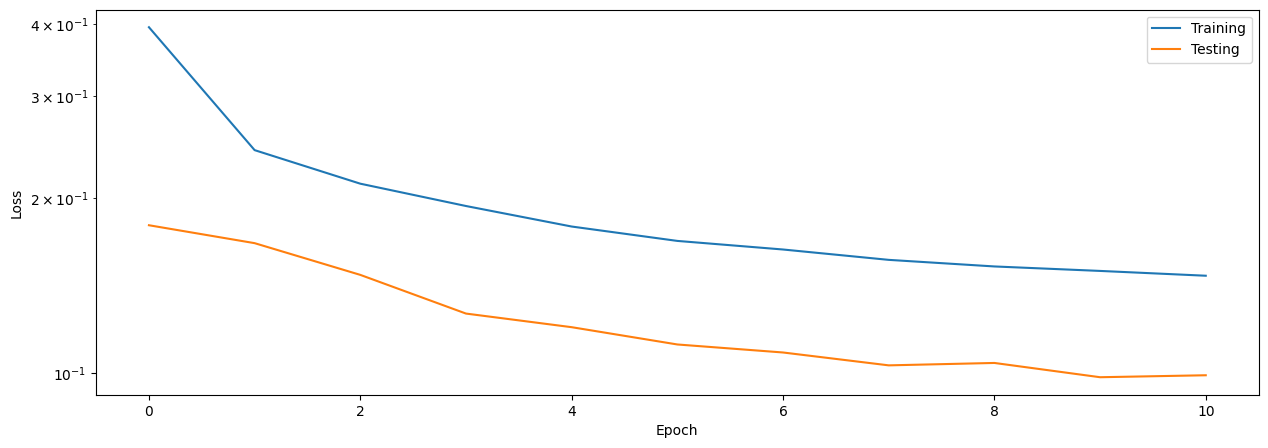

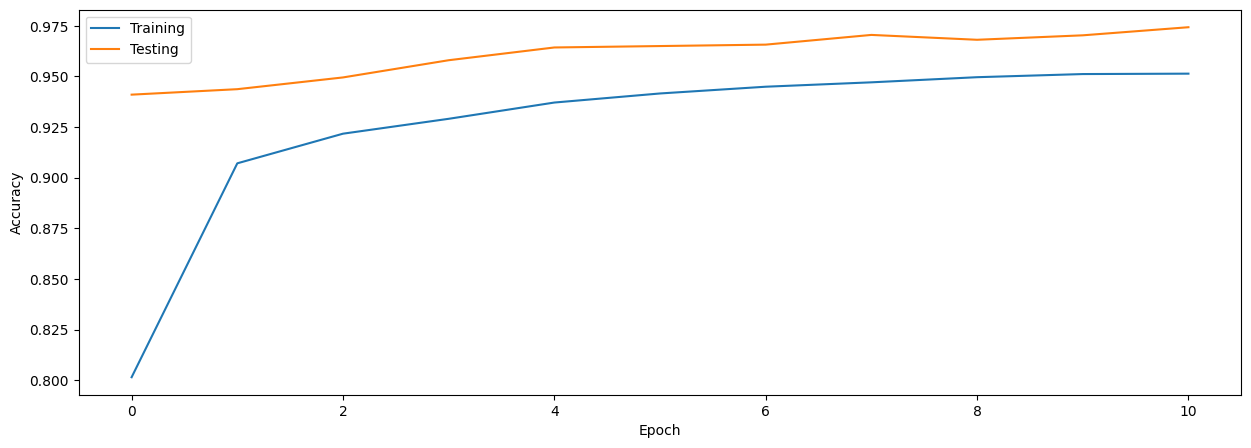

In [ ]:
stats.plot(figsize=(15, 5))

In [63]:
net.load_state_dict(torch.load(trained_folder + '/network.pt'))
net.export_hdf5(trained_folder + '/network.net')

In [65]:
output = net(input.to(device))
for i in range(5):
    inp_event = slayer.io.tensor_to_event(input[i].cpu().data.numpy().reshape(2, 34, 34, -1))
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 10, -1))
    inp_anim = inp_event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    out_anim = out_event.anim(plt.figure(figsize=(10, 5)), frame_rate=240)
    inp_anim.save(f'gifs/inp{i}.gif', animation.PillowWriter(fps=24), dpi=300)
    out_anim.save(f'gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)

In [66]:
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += gif_td(f'gifs/inp{i}.gif')
    html += gif_td(f'gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)

Input,Output
,
,
,
,
,
